# Logistic regression for cardiovascular disease detection
Using a logistic regression to detect CVD results in a model with 72% accuracy on the test set (0.71 and 0.73 on F1 scores for the classes, which is quite good)!

This is still in somewhat draft status as I wait to hear more about the codebook from the dataset uploader. I don't want to make any false assumptions in my interpretation.

Any feedback/questions are welcome.


## Step 1: EDA
Key things I'm looking for:
- data types:  we have a mix of categorical (inc. binary) and continuous variables, we need keep that in mind when preprocessing the data
- class imbalance: the data is approximately balanced, so we won't need to worry about balancing the dataset
- outliers: for the continous variables, we want to keep an eye on whether there are outliers

In [1]:
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv('/kaggle/input/cardio-vascular-disease-detection/cardio_train.csv', delimiter=';')

In [3]:
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69301 entries, 0 to 69300
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           69301 non-null  int64  
 1   age          69301 non-null  int64  
 2   gender       69301 non-null  int64  
 3   height       69301 non-null  int64  
 4   weight       69301 non-null  float64
 5   ap_hi        69301 non-null  int64  
 6   ap_lo        69301 non-null  int64  
 7   cholesterol  69301 non-null  int64  
 8   gluc         69301 non-null  int64  
 9   smoke        69301 non-null  int64  
 10  alco         69301 non-null  int64  
 11  active       69301 non-null  int64  
 12  cardio       69301 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,50471.480397,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,28563.100347,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,988.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25745.000000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50494.000000,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,75150.000000,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Here, I create some data visualizations to get a better sense of the data and next steps:
- Loop through the categorical variables here and create "incidence" charts to help see the incidence (%) of cardiovascular disease by category. This tells me that certain categories definitely do have higher risk. 
- Loop through the continuous variables to get a sense of their distribution and the target. This suggests presence of outliers in most of the continuous variables.

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
def plot_incidence(feature):
    cats = set(data[feature].values)
    
    xs = range(0, len(cats))
    ys_bar=[]
    ys_line = []
    
    for cat in cats:
        ys_bar.append(data[data[feature] == cat].shape[0])
        ys_line.append(data[(data[feature] == cat) & (data.cardio == 1)].shape[0]/data.shape[0] * 100)
    
    fig, ax = plt.subplots()
    
    ax.bar(xs, ys_bar, color='grey')

    ax2 = ax.twinx()
    ax2.plot(xs, ys_line, color='teal')
    
    ax.set_xticks(xs)
    ax.set_xticklabels(cats, rotation=90)
    ax.set_xlabel(feature)
    
    ax.set_ylabel('Frequency (n)')
    ax2.set_ylabel('Incidence (%)')
    
    fig.suptitle(f"Cardio incidence by {feature}")
    
    return plt.show()

In [9]:
cont_vars = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# first I transform the age variable to years instead of days
data.age = data.age.apply(lambda x: x / 365)

cat_vars = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


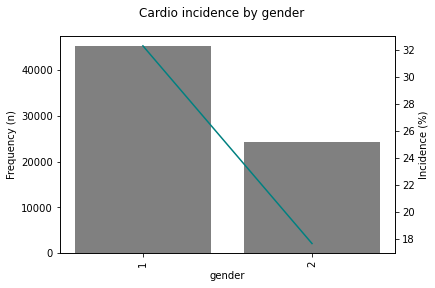

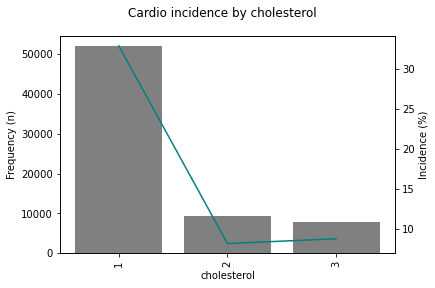

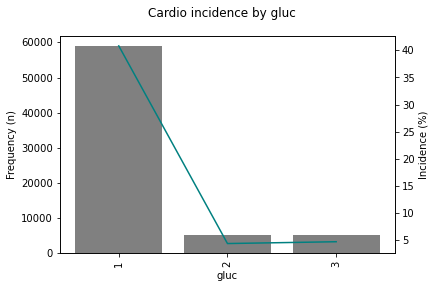

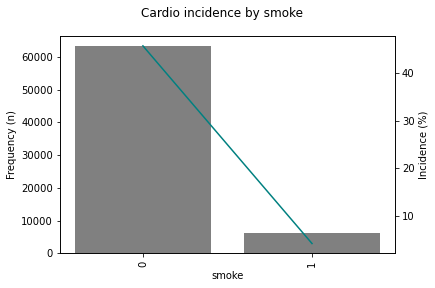

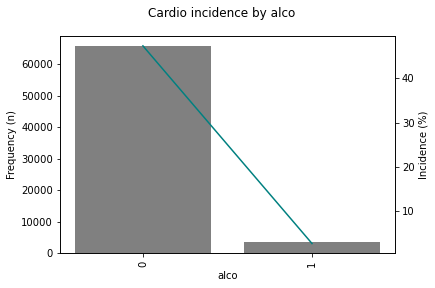

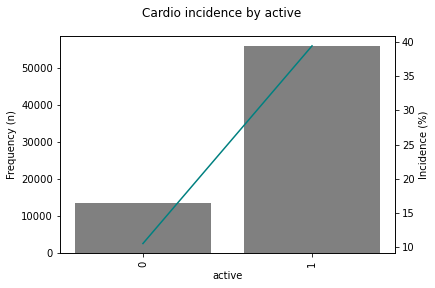

In [10]:
for var in cat_vars:
    plot_incidence(var)

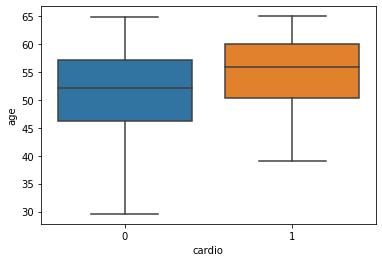

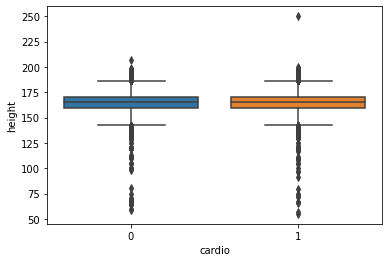

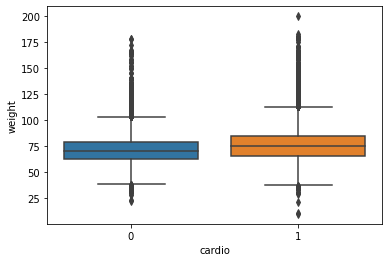

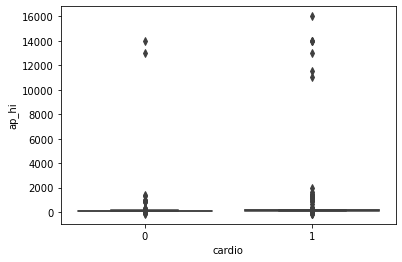

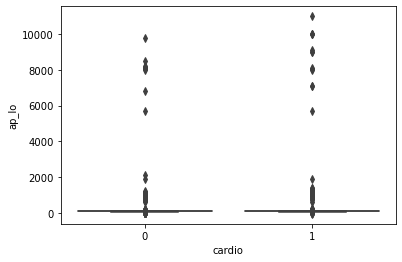

In [11]:
for var in cont_vars:
    _ = sns.boxplot(x='cardio', y=var, data=data)
    plt.show()

## Step 2: Data Processing

In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

In [13]:
# i've decided to engineer the bmi feature and remove the height and weight 
# height and weight in general aren't as informative as their ratio to another 
# i then code the bmi based on the standard categories
data['bmi'] = round(data.weight/data.height * 100, 2)
data['bmi_cat'] = pd.cut(data.bmi, pd.IntervalIndex.from_tuples([(0, 18.5), (18.5, 25), (25, 30), (30, 1000)]))
cat_vars.append('bmi_cat')

cont_vars.remove('height')
cont_vars.remove('weight')

# i also want to make age a categorical variable
data.age = data.age.apply(lambda x: round(x))
data['age_cat'] = pd.qcut(data.age, q=10, duplicates='drop', labels=[x for x in range(0, 10)])

cat_vars.append('age_cat')
cont_vars.remove('age')

# list for my final variables
final_vars = []
final_vars.extend(cont_vars)
final_vars.extend(cat_vars)

In [14]:
# split into train and test set
x_train, x_test, y_train, y_test = train_test_split(data[final_vars], data.cardio, test_size=.1, random_state=42)

In [15]:
# setting up a pipeline to transform categorical variables to one hot encoded variables and to scale continuous variables
ct = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), cat_vars), ('scaler', StandardScaler(), cont_vars)])

# note that we only fit it using data that will be used to fit the model: x_train
ct.fit(x_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('onehot',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 ['gender', 'cholesterol', 'gluc', 'smoke',
                                  'alco', 'active', 'bmi_cat', 'age_cat']),
                                ('scaler',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 ['ap_hi', 'ap_lo'])],
                  verbose=False)

In [16]:
# transforming x_train and x_test according to pipeline
x_train = ct.transform(x_train)
x_test = ct.transform(x_test)

## Step 3: Training the Model

In [17]:
import time

lr = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', refit=True, random_state=42)

start = time.time()
lr.fit(x_train, y_train.values)
end = time.time()
print(f"logistic regression fit in {(end - start) /60} mins")

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

logistic regression fit in 16.485830561319986 mins


## Step 4: Evaluating the Model
Based on the classification report, we have a strong model that does not appear to overfit the problem (as the performance on the train and test are quite similar). 

In [18]:
from sklearn.metrics import classification_report

for key, value in {'TRAIN': [x_train, y_train], 'TEST': [x_test, y_test]}.items():
    preds = lr.predict(value[0])
    print(f"{key} RESULTS\n\n{classification_report(preds, value[1])}\n\n")

TRAIN RESULTS

              precision    recall  f1-score   support

           0       0.77      0.70      0.74     34234
           1       0.68      0.75      0.71     28136

    accuracy                           0.72     62370
   macro avg       0.72      0.73      0.72     62370
weighted avg       0.73      0.72      0.72     62370



TEST RESULTS

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      3712
           1       0.69      0.74      0.71      3219

    accuracy                           0.72      6931
   macro avg       0.72      0.72      0.72      6931
weighted avg       0.72      0.72      0.72      6931





## Step 5: Interpreting the Model

In [19]:
feature_names = []
feature_names.extend(cont_vars)

for cat in cat_vars:
    for val in set(data[cat].values):
        feature_names.append(f"{cat}_{val}")

In [20]:
feature_coefs = {feature: coefficient for feature, coefficient in zip(feature_names, lr.coef_[0])} 

In [21]:
feature_df = pd.Series(feature_coefs).to_frame()
feature_df = feature_df.reset_index()

feature_df.rename(columns={'index': 'feature', 0: 'log_prob'}, inplace=True)

feature_df['odds'] = feature_df.log_prob.apply(np.exp)

In [22]:
feature_df

,feature,log_prob,odds
0,ap_hi,0.000000,1.000000
1,ap_lo,0.009335,1.009379
2,gender_1,-0.466958,0.626907
3,gender_2,0.000000,1.000000
4,cholesterol_1,0.687588,1.988913
5,cholesterol_2,0.000000,1.000000
6,cholesterol_3,0.054290,1.055791
7,gluc_1,-0.269064,0.764095
8,gluc_2,0.098005,1.102968
9,gluc_3,0.000000,1.000000


In [23]:
# manually changing the odds ratio for age_cat_8 because it was stretching the plot too much
feature_df.at[28, 'odds'] = 4

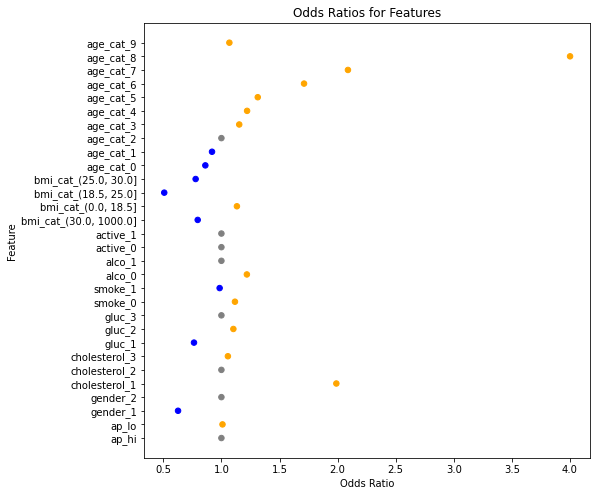

In [24]:
# plotting
ys = [y for y in range(0, 30)]
xs = feature_df.odds.values
cs = []

for x in xs:
    if x < 1:
        cs.append('blue')
    elif x == 1:
        
        cs.append('grey')
    else:
        cs.append('orange')
    
fig = plt.figure(figsize=(8, 8))
_ = plt.scatter(xs, ys,s=30,color=cs)

plt.yticks(ticks=ys, labels=feature_df.feature.values)
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.title('Odds Ratios for Features')
plt.show()

My preliminary interpretation is:
- risk increases with age, with particularly high risk at age 61-62 (age_cat_8)
- risk is also higher for gender 2 (I assume this is male)
- risk is highest for the underweight BMI, interestingly (BMI 0-18.5%)
- risk is highest with above normal glucose readings (interestingly not with the well above normal readings)